In [3]:
#%% 1. Load the required libraries

#Basic libaries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#3d libraries
import open3d as o3d
import laspy
print(laspy.__version__)

#Geospatial libraries
import rasterio
import alphashape as ash
import geopandas as gpd
import shapely as sh

from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.features import  shapes
from shapely.geometry import Polygon

C:\Users\asmig\AppData\Local\Temp\ipykernel_9604\316830921.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
2.5.3


## Data Preparation

In [4]:
#%% 2. Data Preparation

#LiDAR data point cloud
las = laspy.read('lidardata.las')

#Explore the classification field
print(np.unique(las.classification))
print([dimension.name for dimension in las.point_format.dimensions])

#Show the coordinate projection system for data
crs = las.vlrs[2].string
print(crs)

[1 2 3 5 6 7]
['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']
PROJCS["NAD_1983_UTM_Zone_10N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-123.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0],AUTHORITY["EPSG",26910]]


In [5]:
#%% 3. Data Pre-Processing

#%% 3.1 Building points initialization 
# Create a mask to filter points
pts_mask = las.classification == 6

# Apply mask and get coordinates of filtered dataset (this will be transposed)
xyz_t = np.vstack((las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]))

# Transform to open3d.o3d.geometry.PointCloud and visualize
pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(xyz_t.transpose())

# Translate the point cloud, and keep the translation to reapply at the end
pcd_center = pcd_o3d.get_center()
pcd_o3d.translate(-pcd_center)

# Visualize the results
o3d.visualization.draw_geometries([pcd_o3d])


#### Generated Open3D Result:
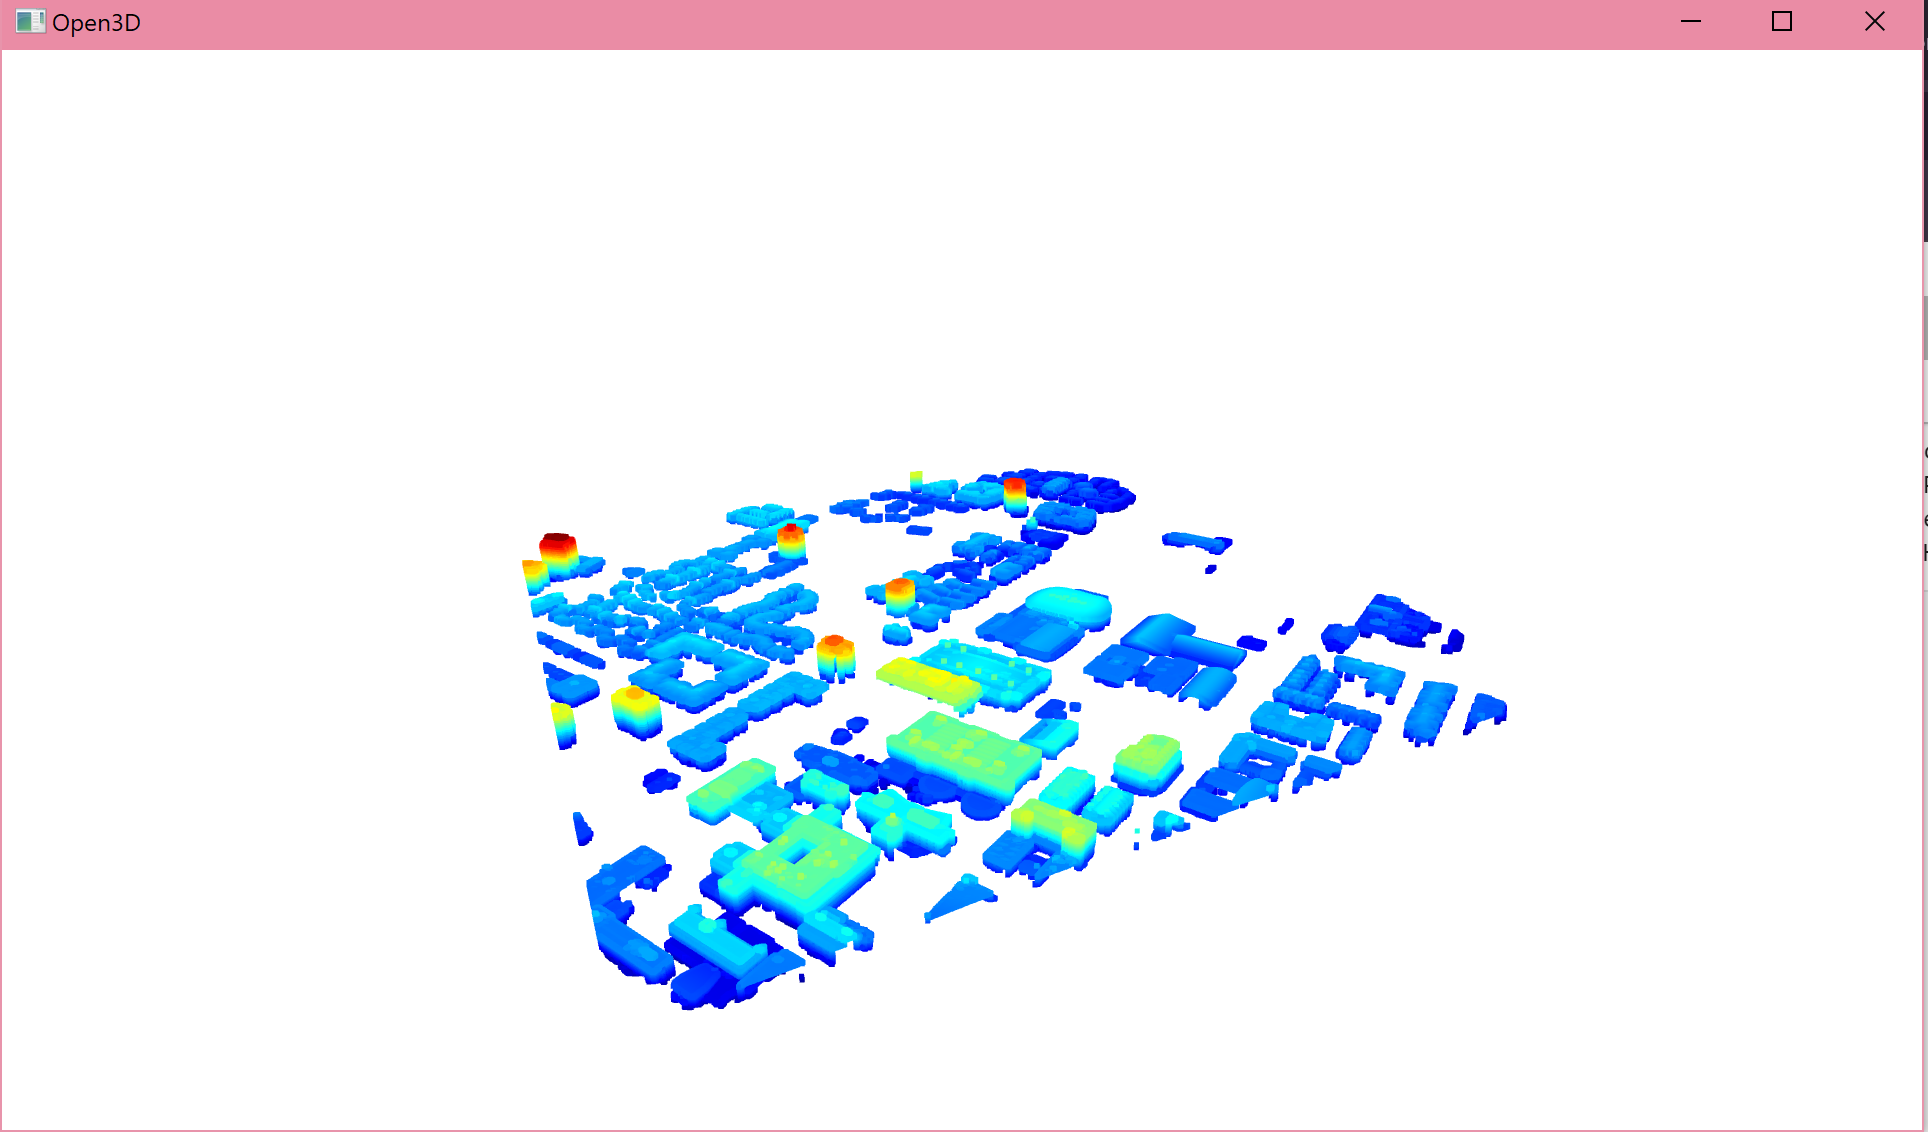

In [6]:
#%% 3.2 Isolating ground points
pts_mask = las.classification == 2
xyz_t = np.vstack((las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]))

ground_pts = o3d.geometry.PointCloud()
ground_pts.points = o3d.utility.Vector3dVector(xyz_t.transpose())
ground_pts.translate(-pcd_center)

# Visualize the results
o3d.visualization.draw_geometries([ground_pts])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


#### Generated Open3D Result:
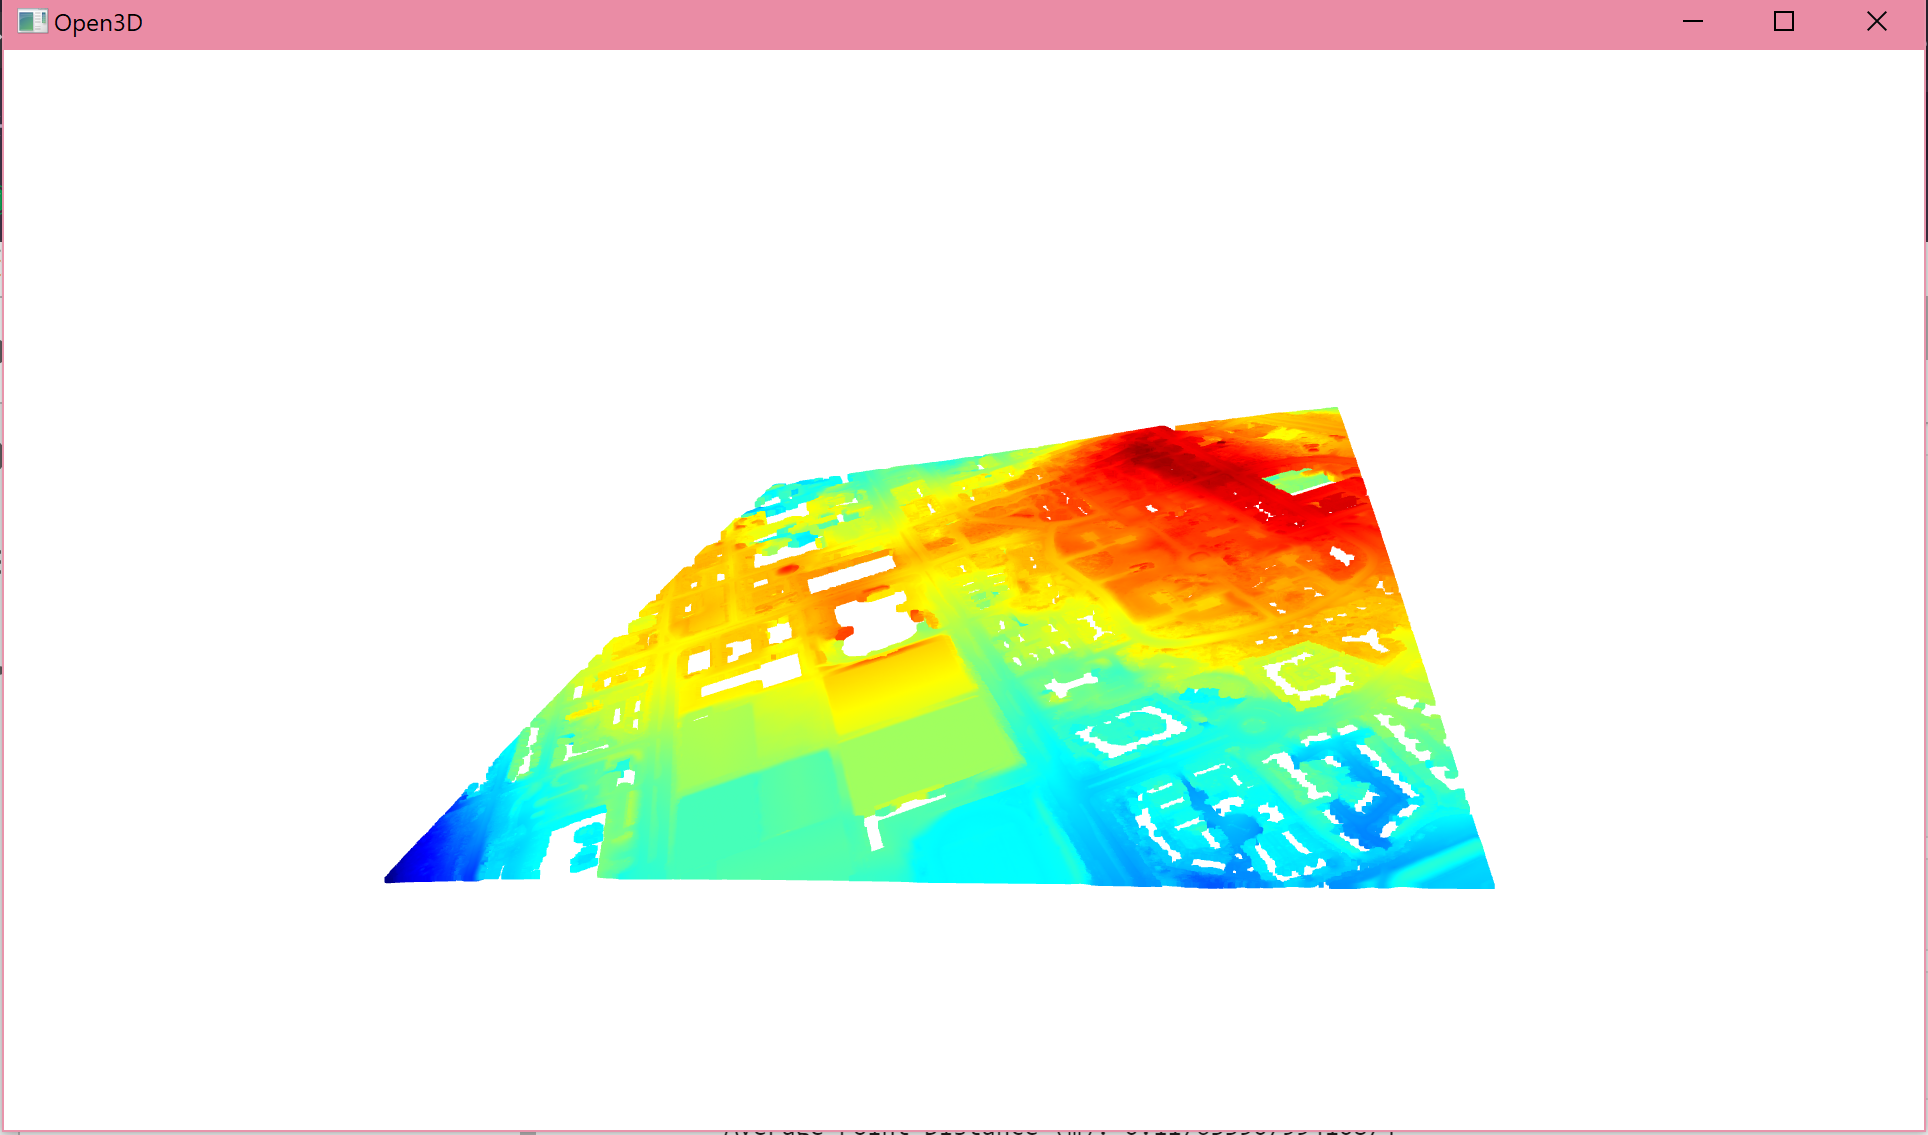

In [7]:
#%% 3.3 Identify average distance between the buildings (points)
nn_distance = np.mean(pcd_o3d.compute_nearest_neighbor_distance())
print("Average Point Distance (m):", nn_distance)

Average Point Distance (m): 0.11763390799410874


## Instance Segmentation, Vectorization & Modelling

In [9]:
#%% 4. Unsupervised segmentation (Clustering) w/ DBSCAN

# Now working in a local frame of reference, essential not to get stuck at truncated coordinates

# Definition of the parameters epsilon, and the minimum number of points to be considered a relevant cluster
epsilon = 0.5
min_cluster_points = 25

labels = np.array(pcd_o3d.cluster_dbscan(eps=epsilon, min_points=min_cluster_points))
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")

# Use a discrete color pallette to randomize visualization
colors = plt.get_cmap("tab20")(labels/ (max_label if max_label > 0 else 1))
colors[labels<0] = 0
pcd_o3d.colors= o3d.utility.Vector3dVector(colors[:,:3])

# Visualization
o3d.visualization.draw_geometries([pcd_o3d])

point cloud has 11302 clusters


#### Generated Open3D Result:
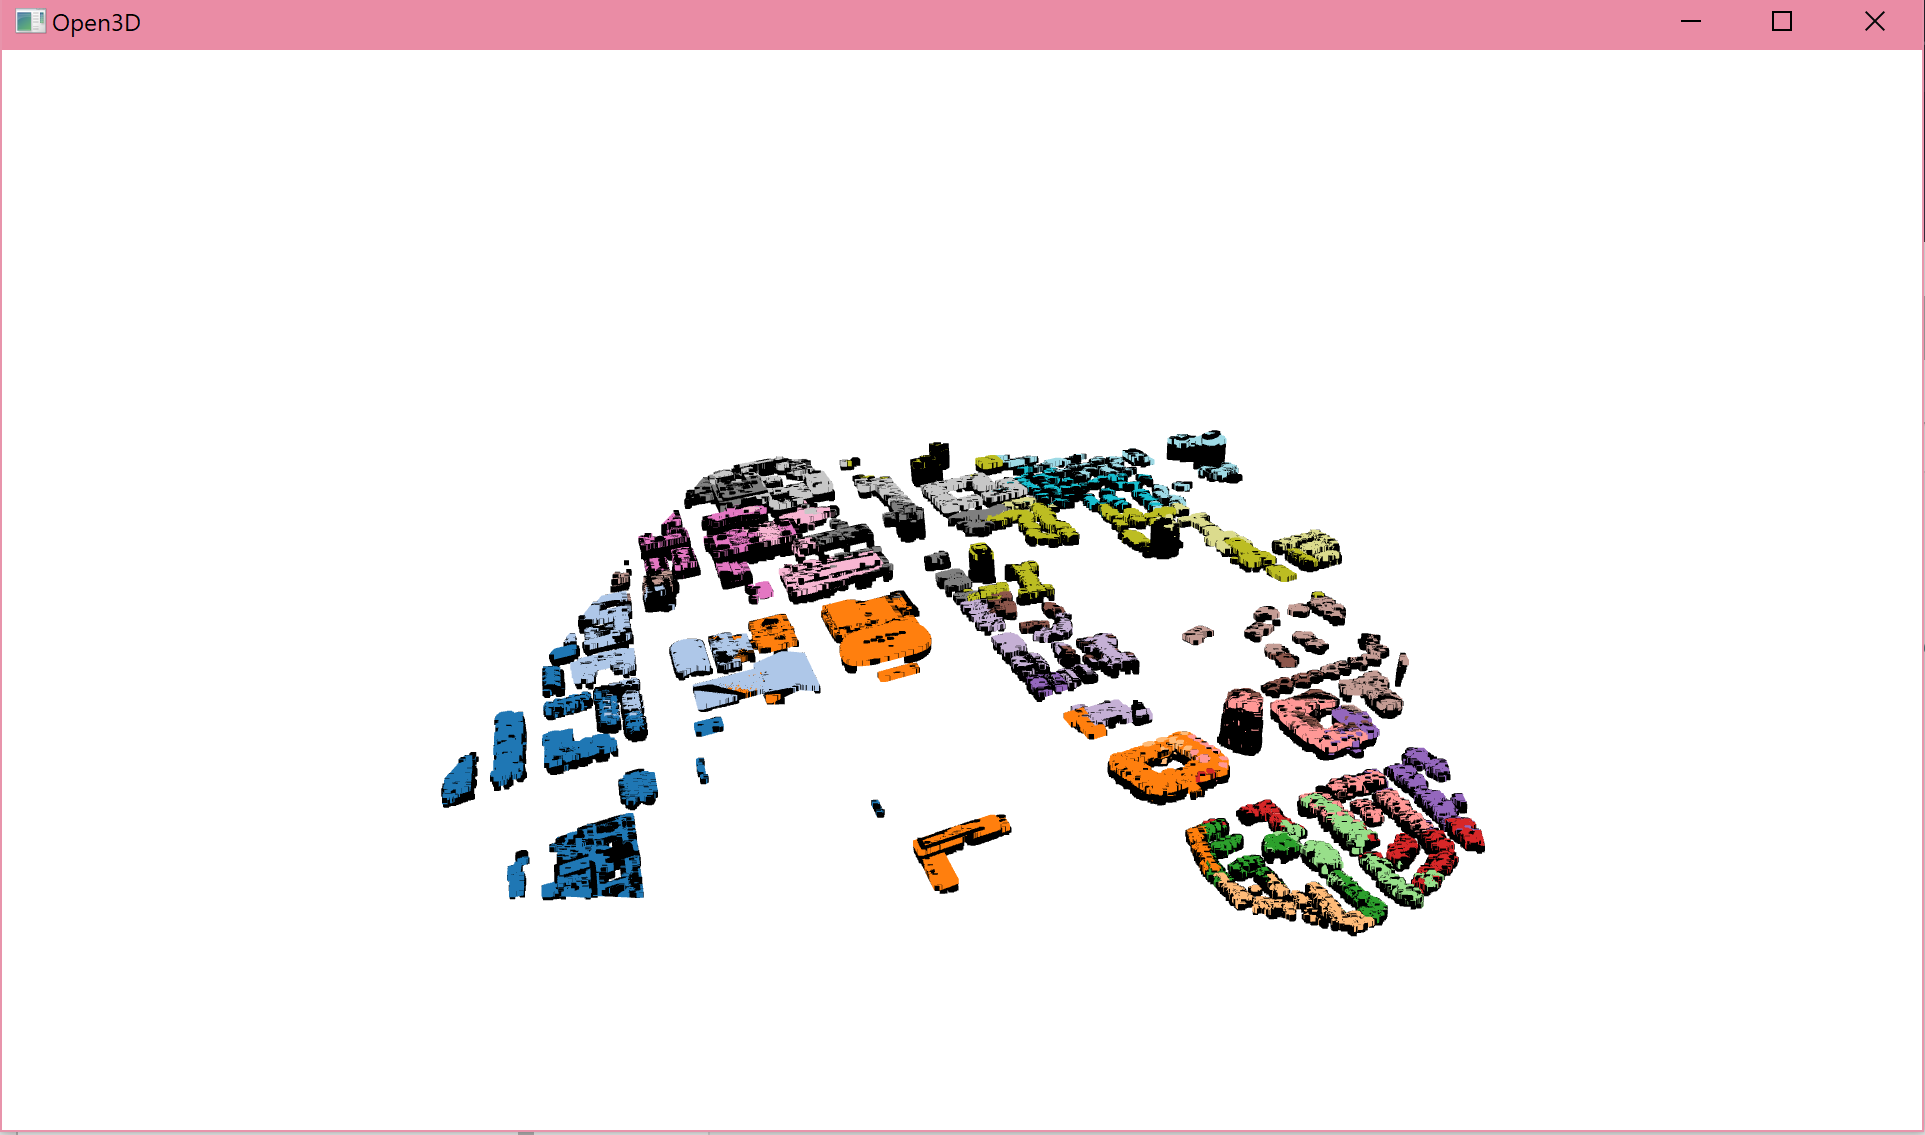

In [10]:
#%% 5. Select a segment to be considered
sel = 1
segment = pcd_o3d.select_by_index(np.where(labels==sel)[0])
o3d.visualization.draw_geometries([segment])

#### Generated Open3D Result:
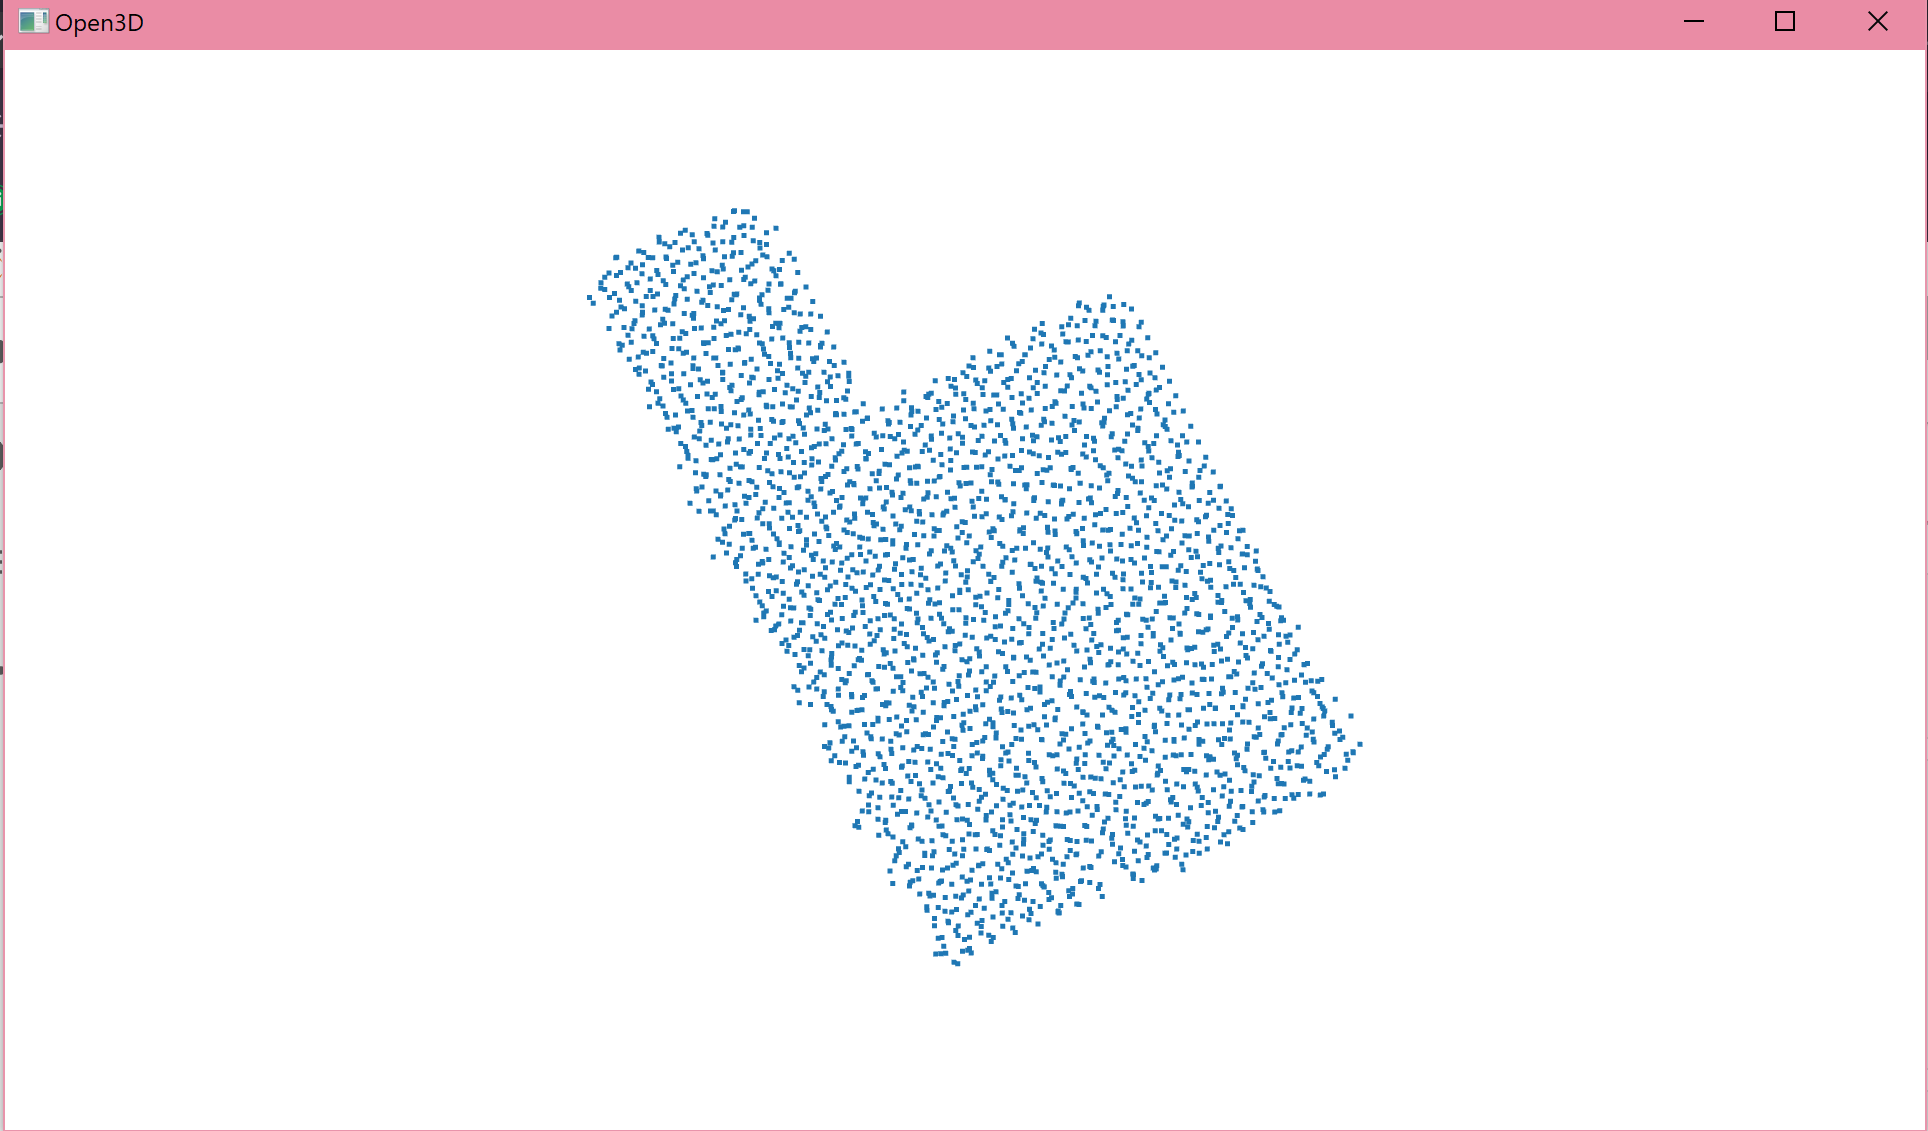

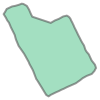

In [11]:
#%% 6. Extracting the outline (building footprint) of the selection

# Extract only the X and Y coordinates of our point cloud (local)
points_2D = np.asarray(segment.points)[:,0:2]

# Compute the shape of selected building and return result with shapely
building_vector = ash.alphashape(points_2D, alpha=0.5)
building_vector

In [12]:
#%% 6.1 Store the 2D polygon in a Geodataframe
building_gdf = gpd.GeoDataFrame(geometry=[building_vector], crs='EPSG:26910')
building_gdf.head(1)

,geometry
0,"POLYGON ((-293.478 -523.959, -294.726 -524.508..."


In [13]:
#%% 7. Computing Semantics & Attributes

#%% 7.1 Relative height of building

# First define ground level in local area
query_point = segment.get_center()
query_point[2] = segment.get_min_bound()[2]
pcd_tree = o3d.geometry.KDTreeFlann(ground_pts)
[k, idx, _] = pcd_tree.search_knn_vector_3d(query_point, 200)

# From the nearest neighbor search, extract the ground points and color them grey
sample = ground_pts.select_by_index(idx, invert=False)
sample.paint_uniform_color([0.5, 0.5, 0.5])
o3d.visualization.draw_geometries([sample, ground_pts])

# Extract the mean value of the ground in this specific place
ground_zero = sample.get_center()[2]

# Compute true height of the building, including the 
height = segment.get_max_bound()[2] - ground_zero
print('True Height: ', height)


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
True Height:  4.634854999999995


#### Generated Open3D Result:
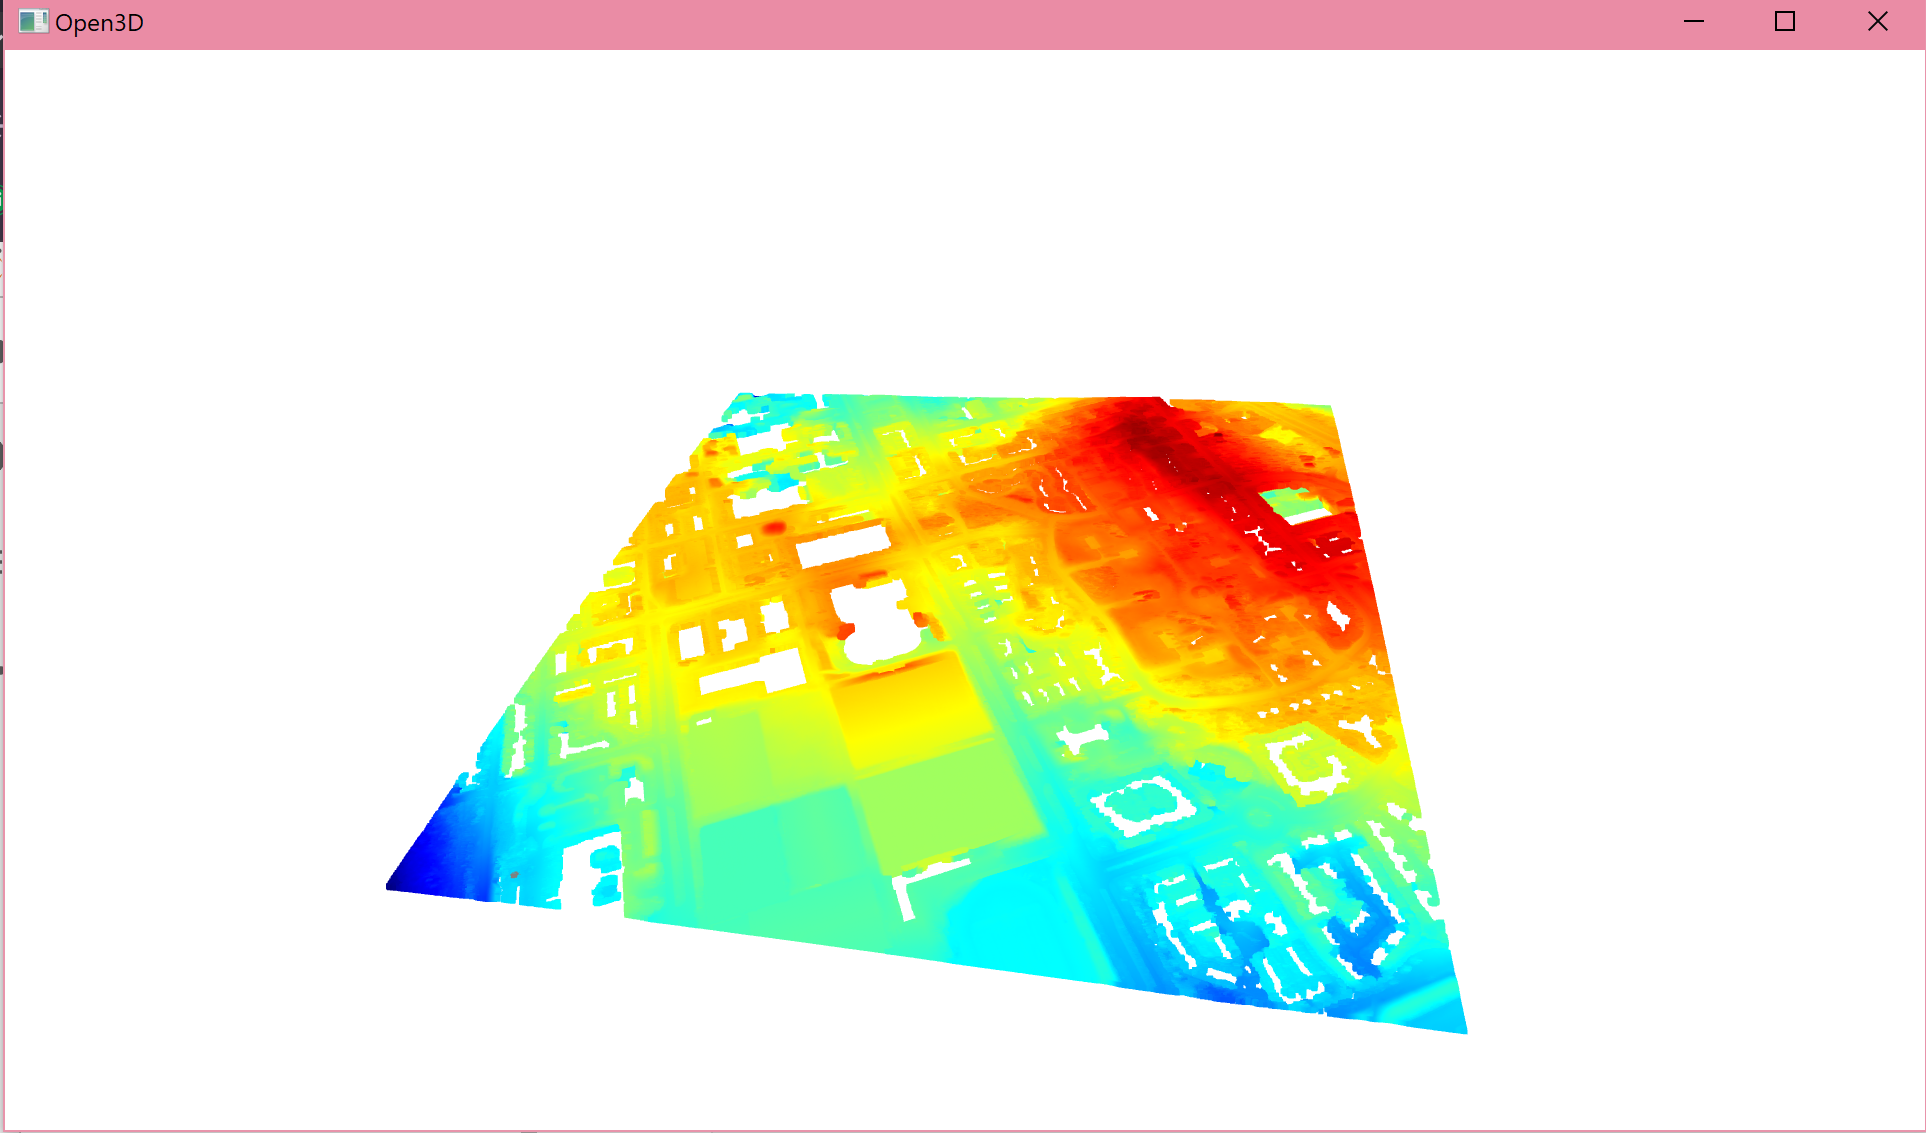

In [14]:
#%% 7.2 Computing Parameters
building_gdf[['id']] = sel
building_gdf[['height']] = segment.get_max_bound()[2] - sample.get_center()[2]
building_gdf[['area']] = building_vector.area
building_gdf[['perimeter']] = building_vector.length
building_gdf[['local_cx','local_cy','local_cz']] = np.asarray([building_vector.centroid.x, building_vector.centroid.y, sample.get_center()[2]])
building_gdf[['transl_x','transl_y','transl_z']] = pcd_center
building_gdf[['pts_number']] = len(segment.points)

# Print it out
building_gdf.head(1)

,geometry,id,height,area,perimeter,local_cx,local_cy,local_cz,transl_x,transl_y,transl_z,pts_number
0,"POLYGON ((-293.478 -523.959, -294.726 -524.508...",1,4.634855,82.3868,39.036204,-296.884269,-519.353794,-18.054634,482429.585606,5.456545e+06,107.181779,2862


The local minima (along the Z axis) -14.916779411668927
The local maxima (along the Z axis) -13.419779411668927


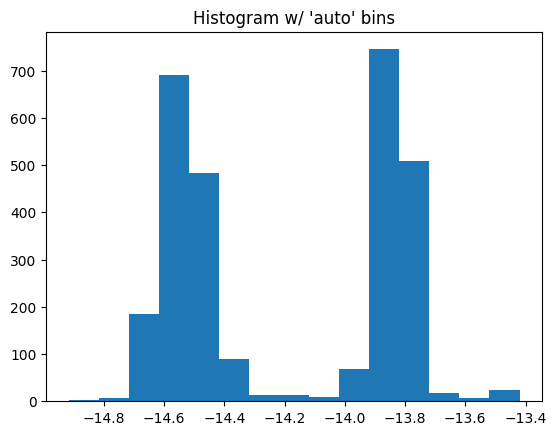

In [15]:
#%% 7.3 Extra Attributes
points_1D = np.asarray(segment.points)[:,2]
print('The local minima (along the Z axis)', np.min(points_1D))
print('The local maxima (along the Z axis)', np.max(points_1D))

plt.hist(points_1D, bins='auto') # arguments are passed to np.histogram
plt.title("Histogram w/ 'auto' bins")
plt.show()

In [16]:
#%% 8. 2D to 3D Library: Turning a Shapely vector dataset to an Open3D lineset

#%% 8.1 The Base Layer
#Generate the vertice list
vertices = list(building_vector.exterior.coords)

#Construct the Open3D Object
polygon_2d = o3d.geometry.LineSet()
polygon_2d.points = o3d.utility.Vector3dVector([point+(0,) for point in vertices])
polygon_2d.lines = o3d.utility.Vector2iVector([(i, (i+1) % len(vertices)) for i in range (len(vertices))])

#Visualize
o3d.visualization.draw_geometries([polygon_2d])

#### Generated Open3D Result:
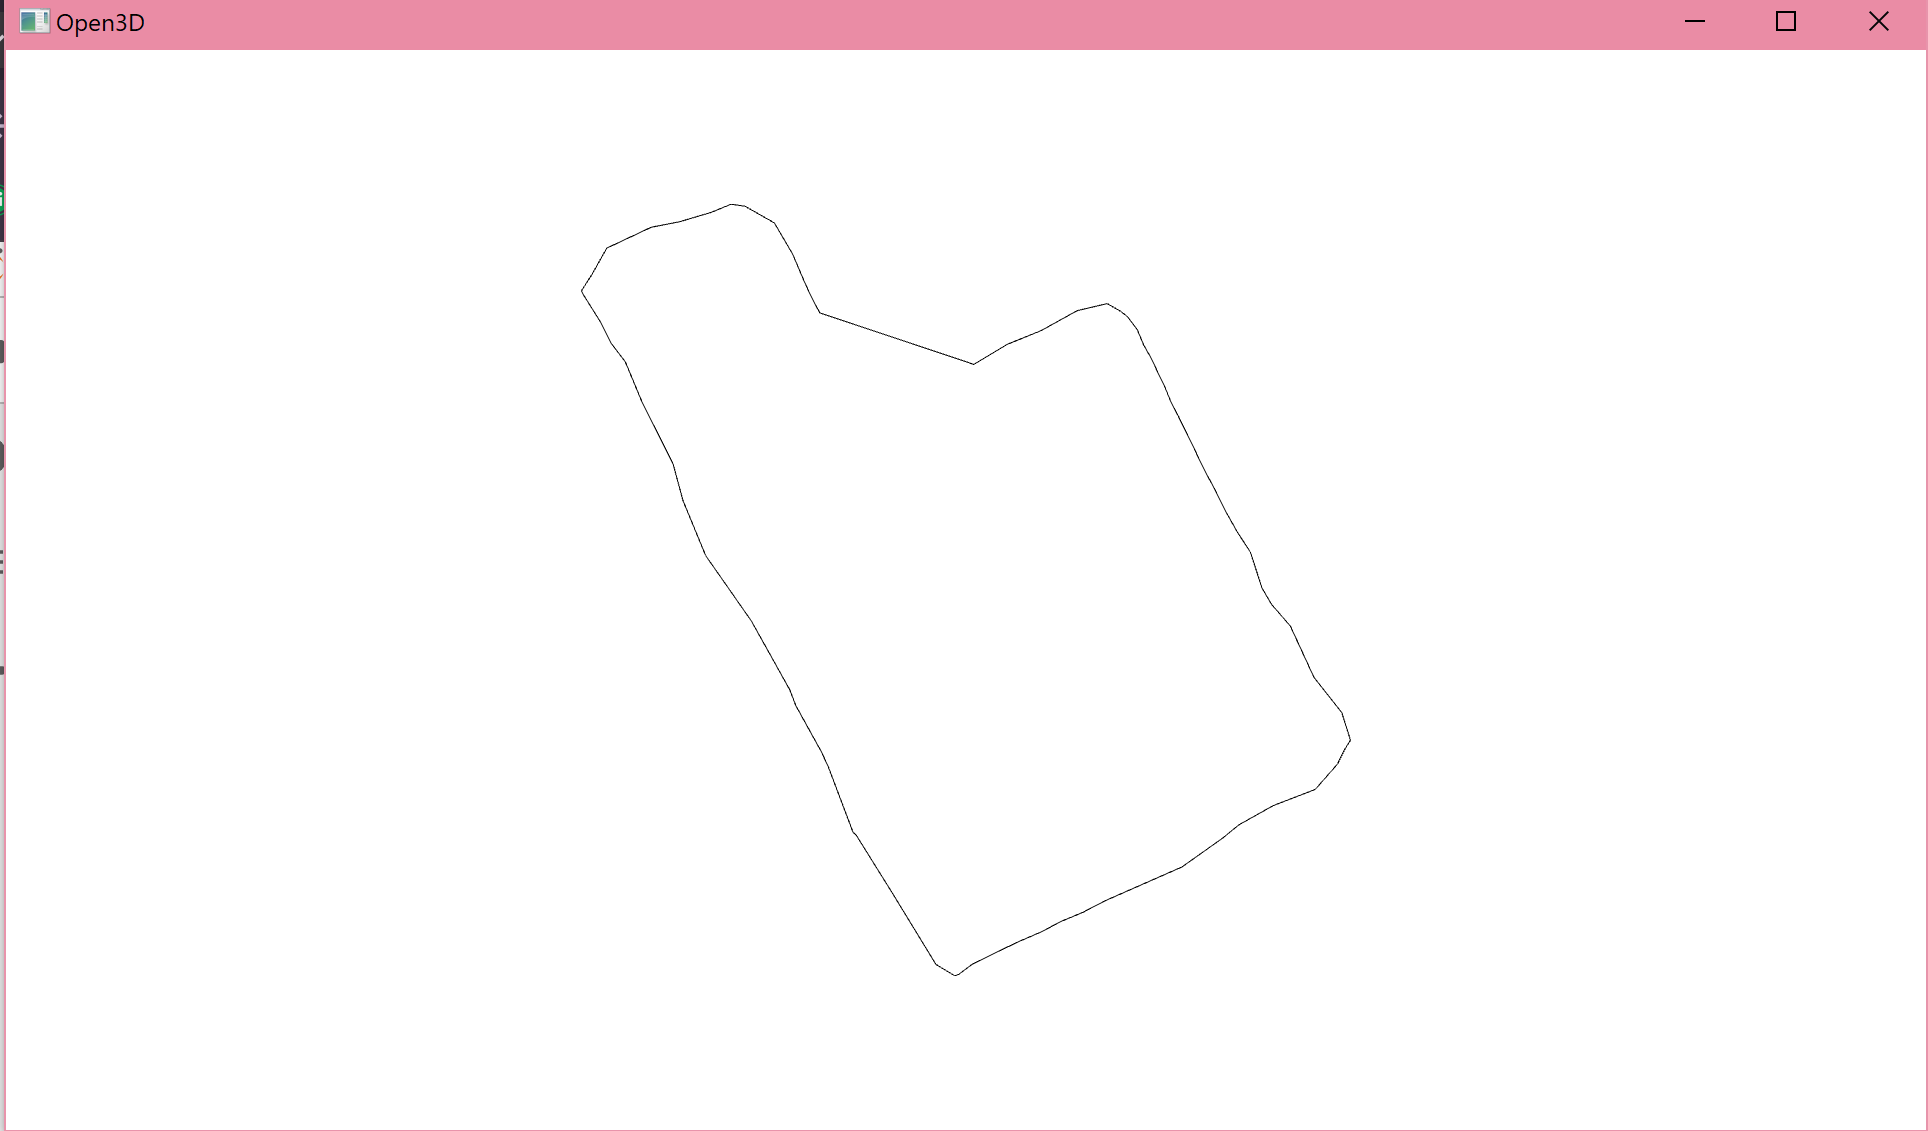

In [17]:
#%% 8.2 The Top Layer
# Generate the same element for "extruded" parts
extrusion = o3d.geometry.LineSet()
extrusion.points = o3d.utility.Vector3dVector([point + (height,) for point in vertices])
extrusion.lines = o3d.utility.Vector2iVector([(i, (i + 1) % len(vertices)) for i in range(len(vertices))])
o3d.visualization.draw_geometries([polygon_2d, extrusion])

# Plot the vertices
temp = polygon_2d + extrusion
temp.points
temp_o3d = o3d.geometry.PointCloud()
temp_o3d.points = temp.points
o3d.visualization.draw_geometries([temp_o3d])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


#### Generated Open3D Result for Extrusion:
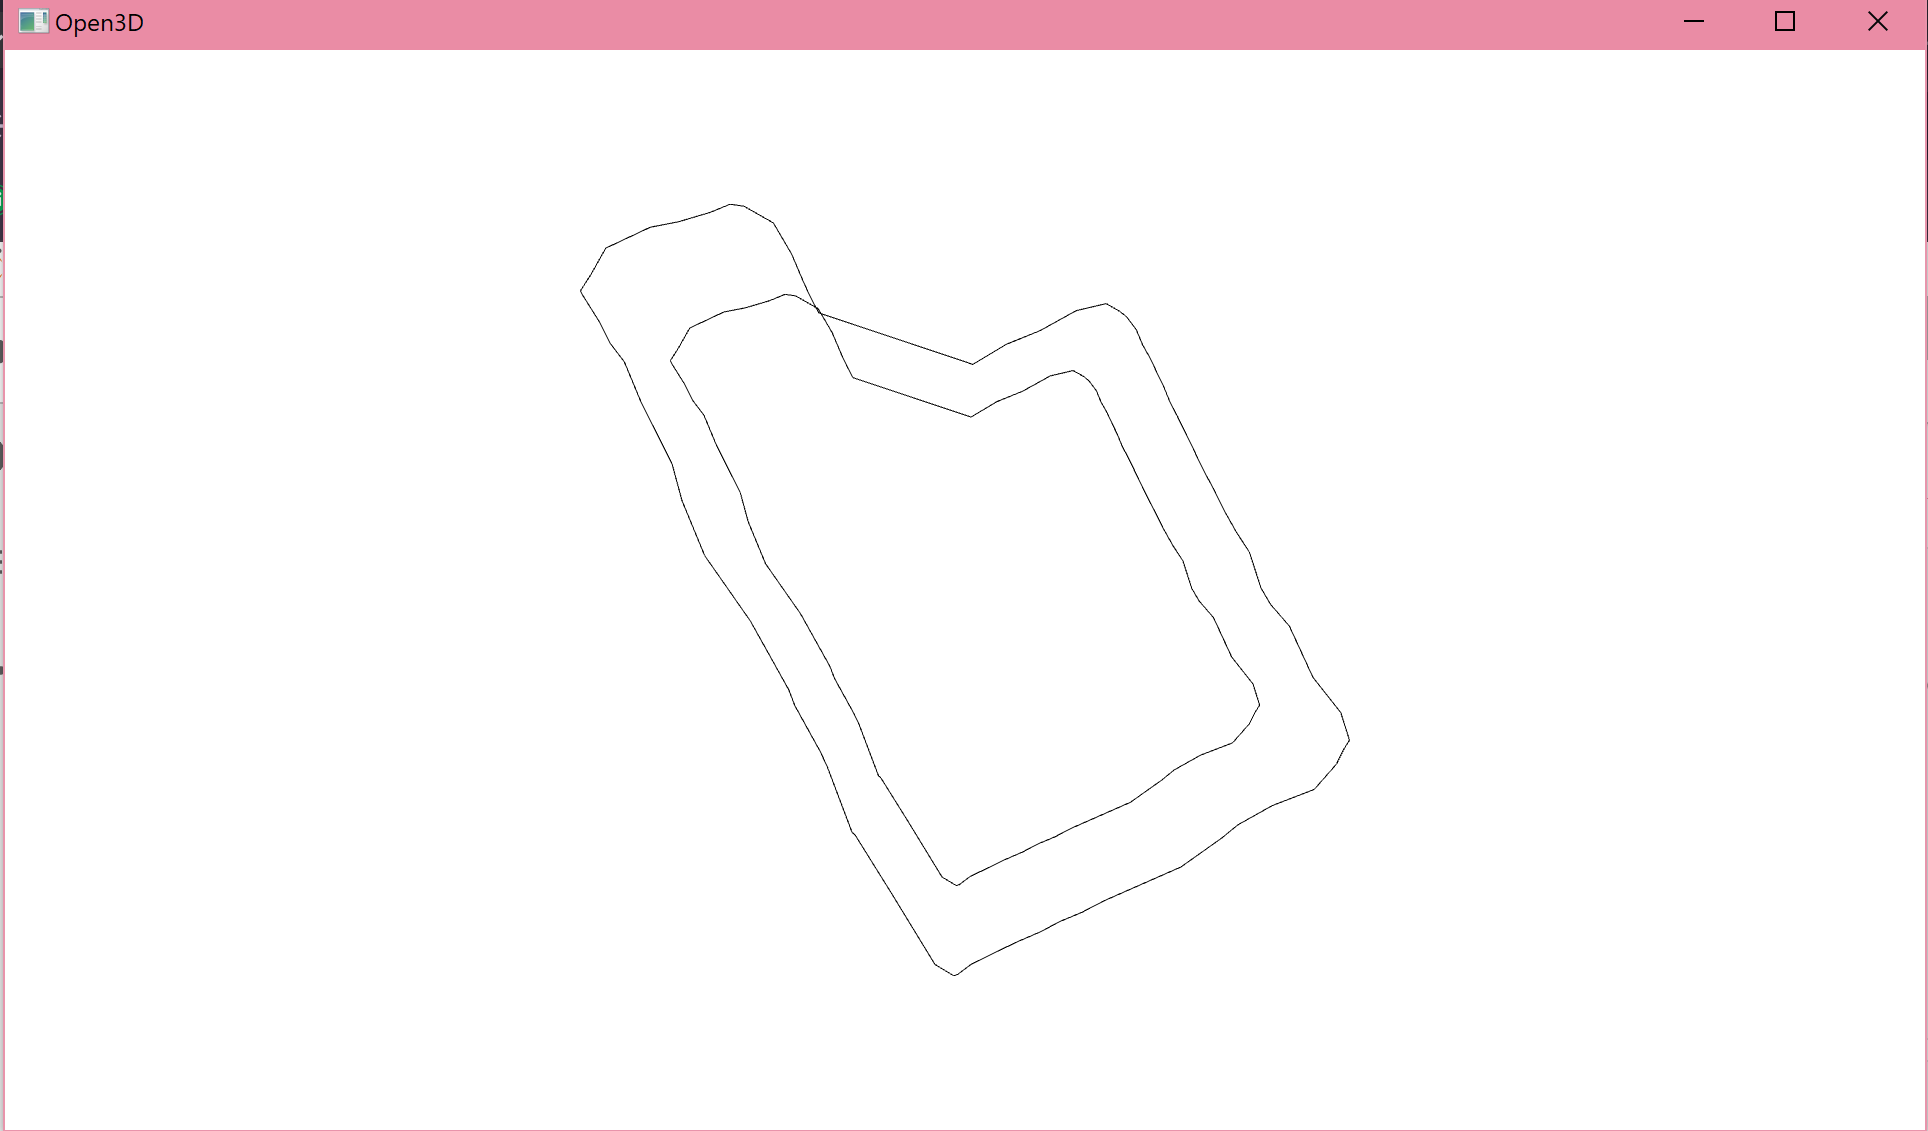

#### Generated Open3D Result for Plotted Vertices:
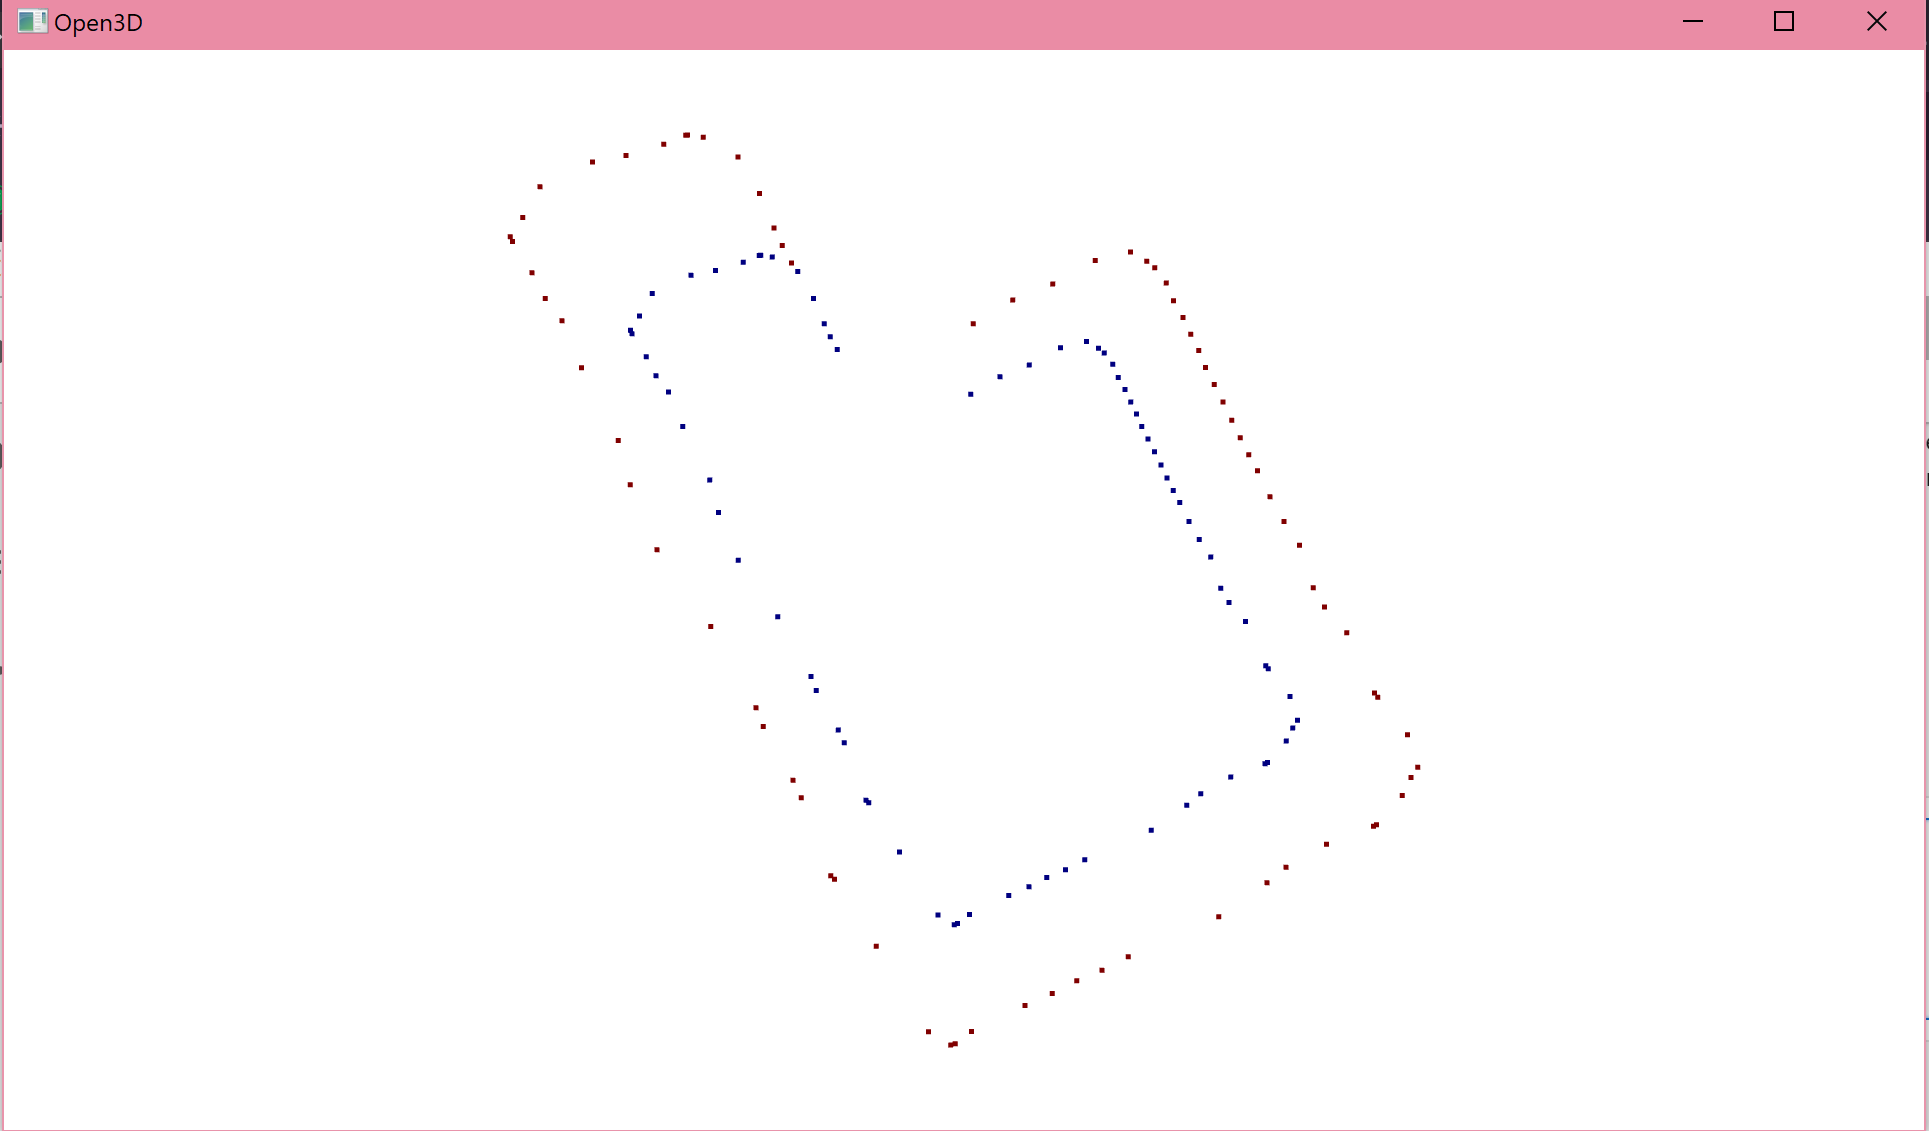
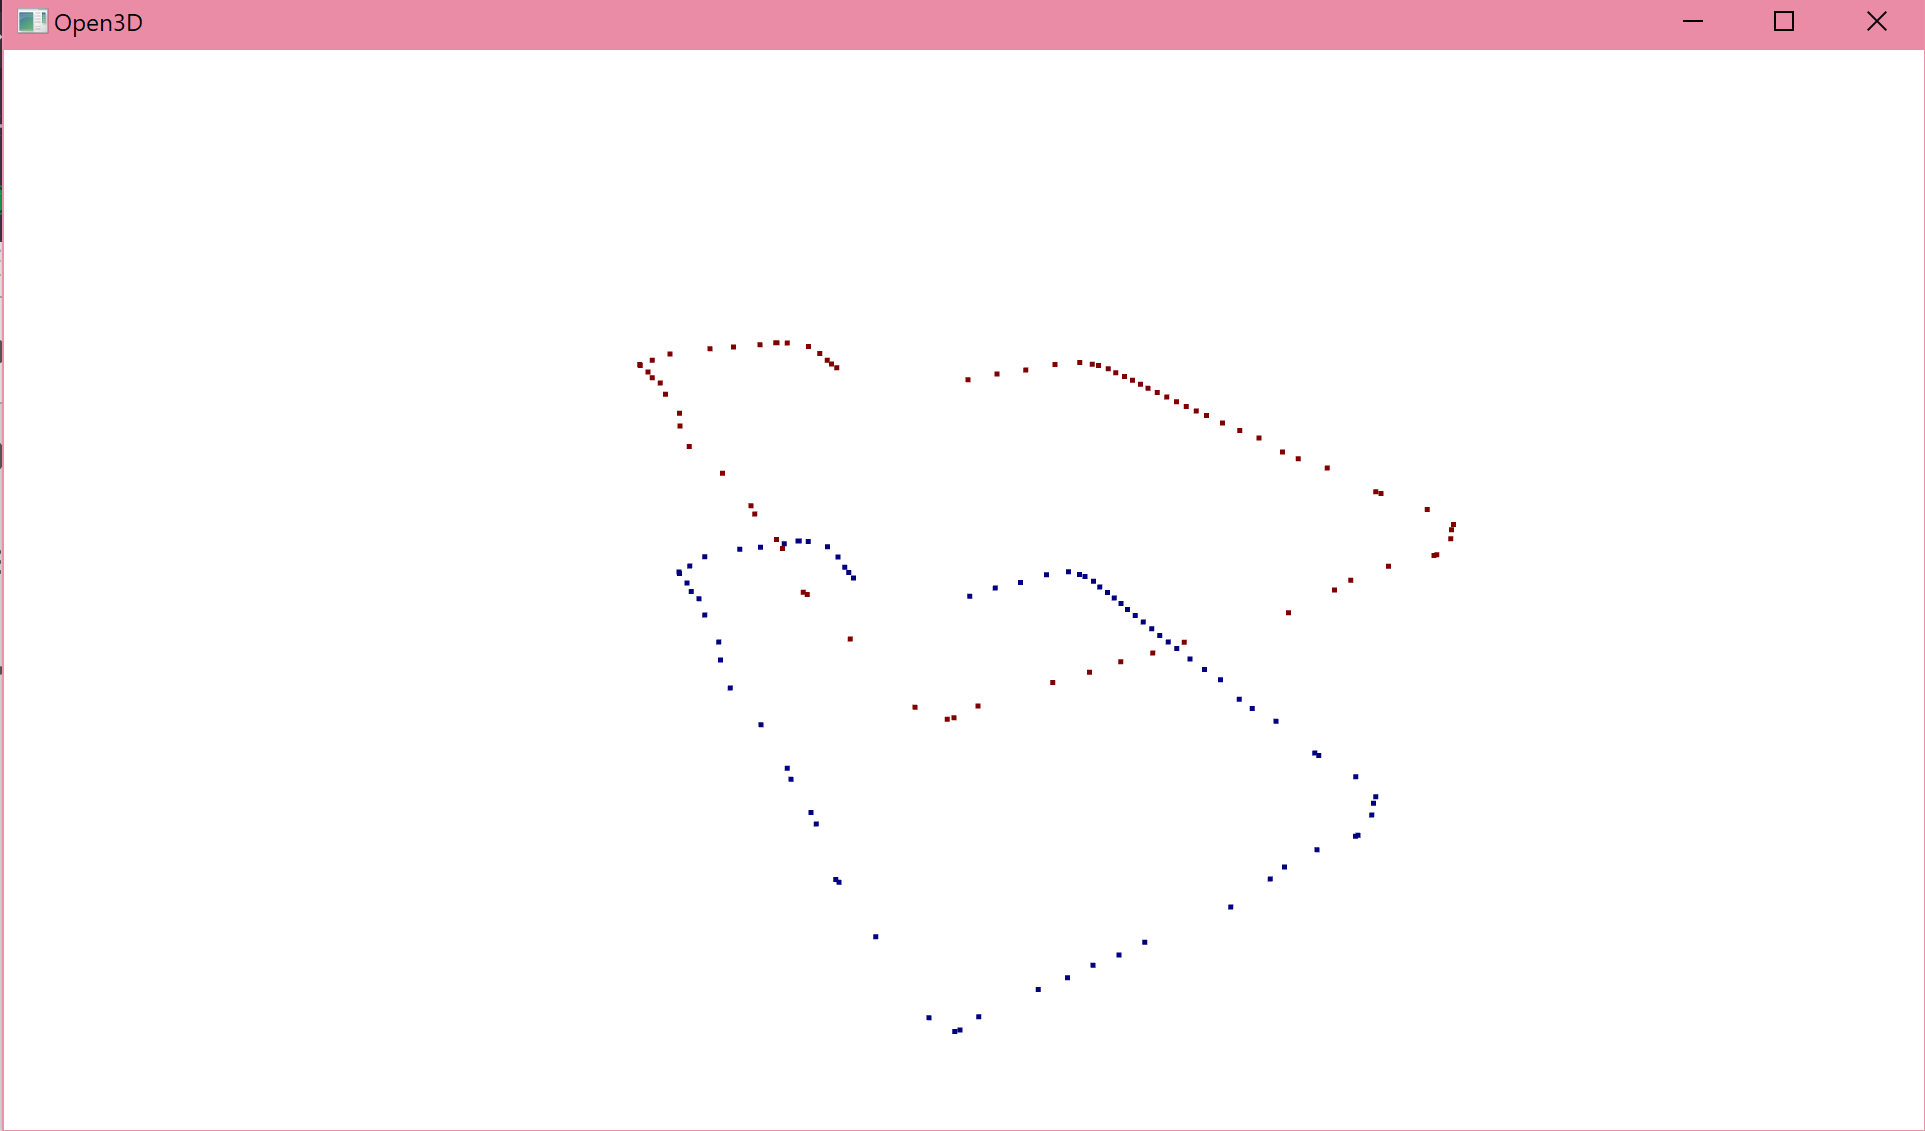

In [20]:
#%% 9. Generate the base vertices for the 3D mesh w/ Numpy
a = np.array(building_vector.exterior.coords)
b = np.ones([a.shape[0],1])*sample.get_center()[2]
c = np.ones([a.shape[0],1])*(sample.get_center()[2]+height)

# Define the ground footprint and height arrays of the points
ground_pc=np.hstack((a,b))
up_pc =np.hstack((a,c))

# Generate an Open3D Point Cloud made of the major points
temp_o3d = o3d.geometry.PointCloud()
temp_o3d.points = o3d.utility.Vector3dVector(np.concatenate((ground_pc, up_pc), axis=0))
o3d.visualization.draw_geometries([temp_o3d])

#### Generated Open3D Result:
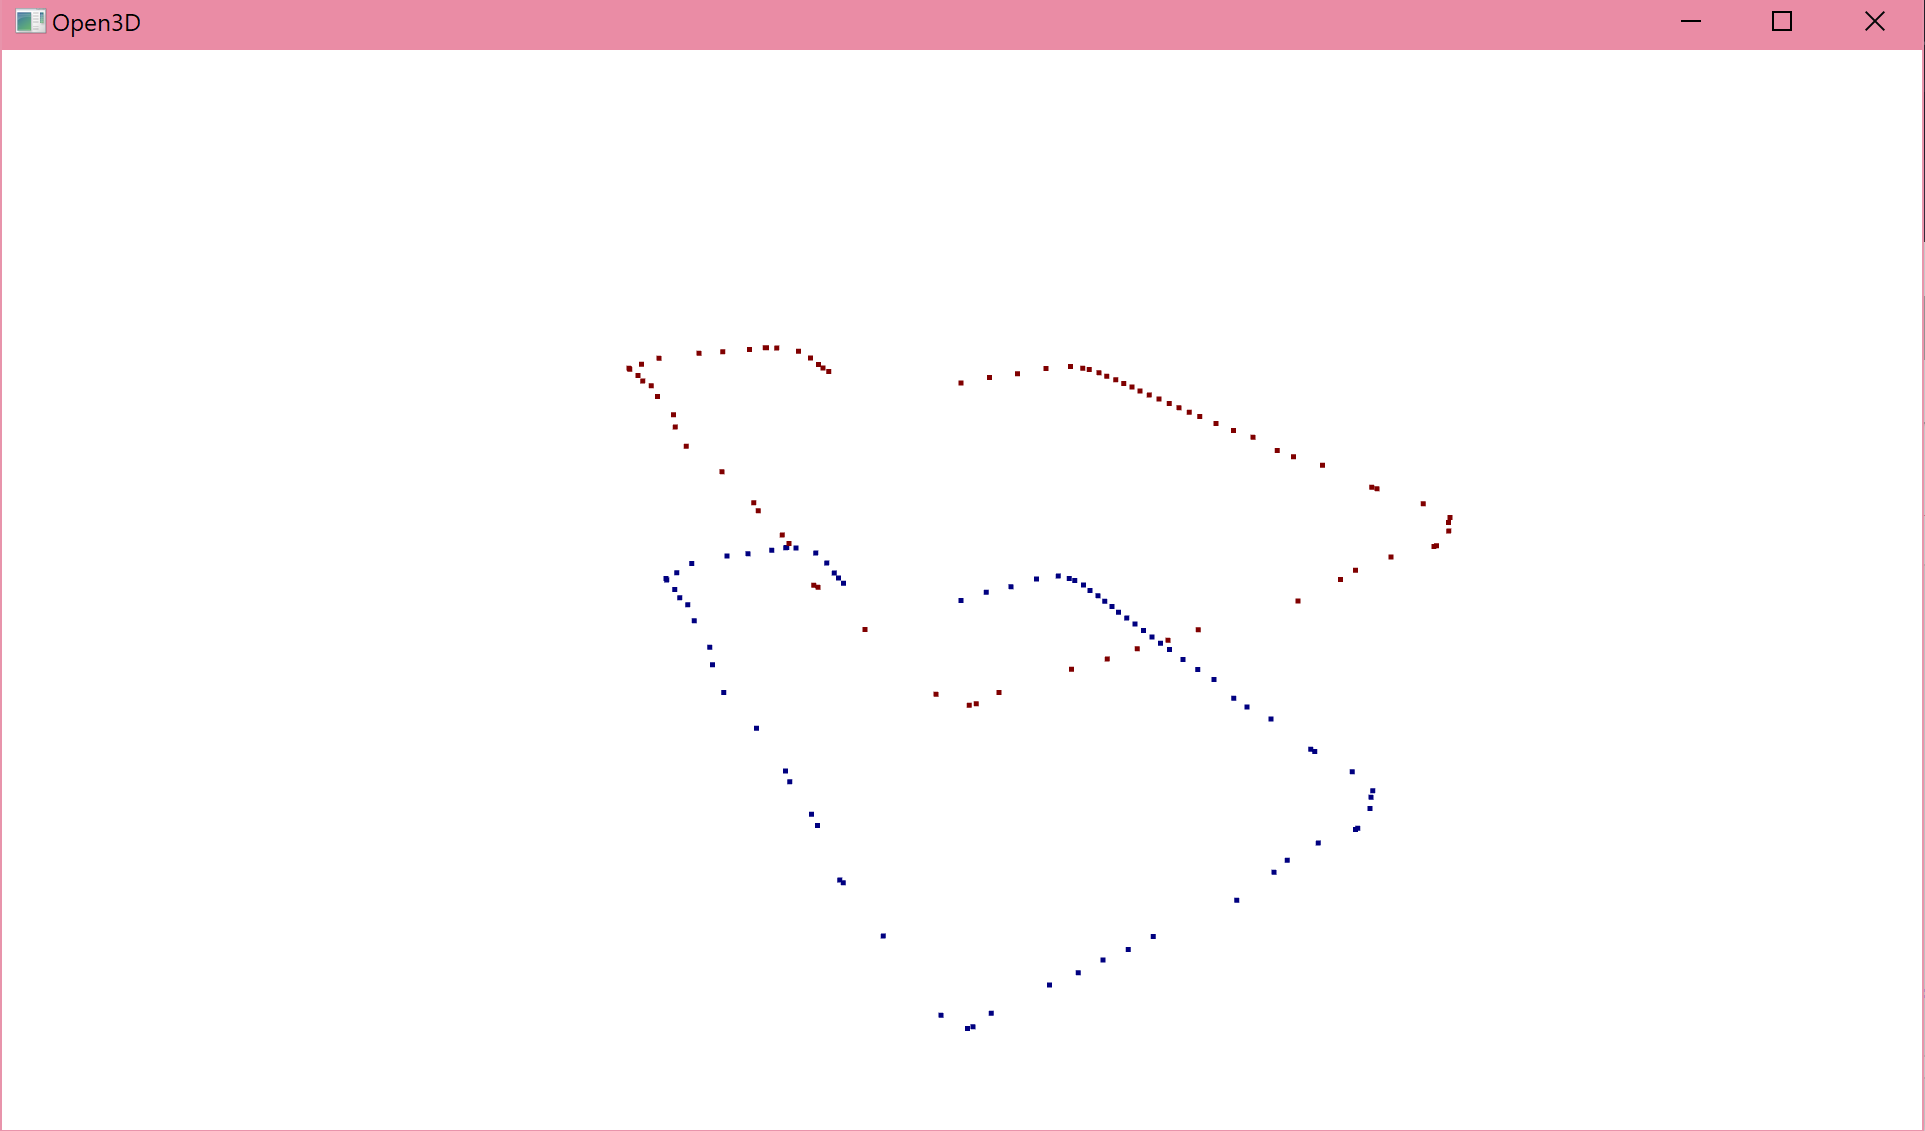

In [21]:
#%% 10. Compute the shape of the 3D base points
alpha = 20
print(f"alpha={alpha:.3f}")
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(temp_o3d, alpha)
mesh.compute_vertex_normals()
mesh.paint_uniform_color([0.5, 0.4, 0])
o3d.visualization.draw_geometries([temp_o3d, mesh, segment], mesh_show_back_face=True)

alpha=20.000
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra

#### Generated Open3D Result:
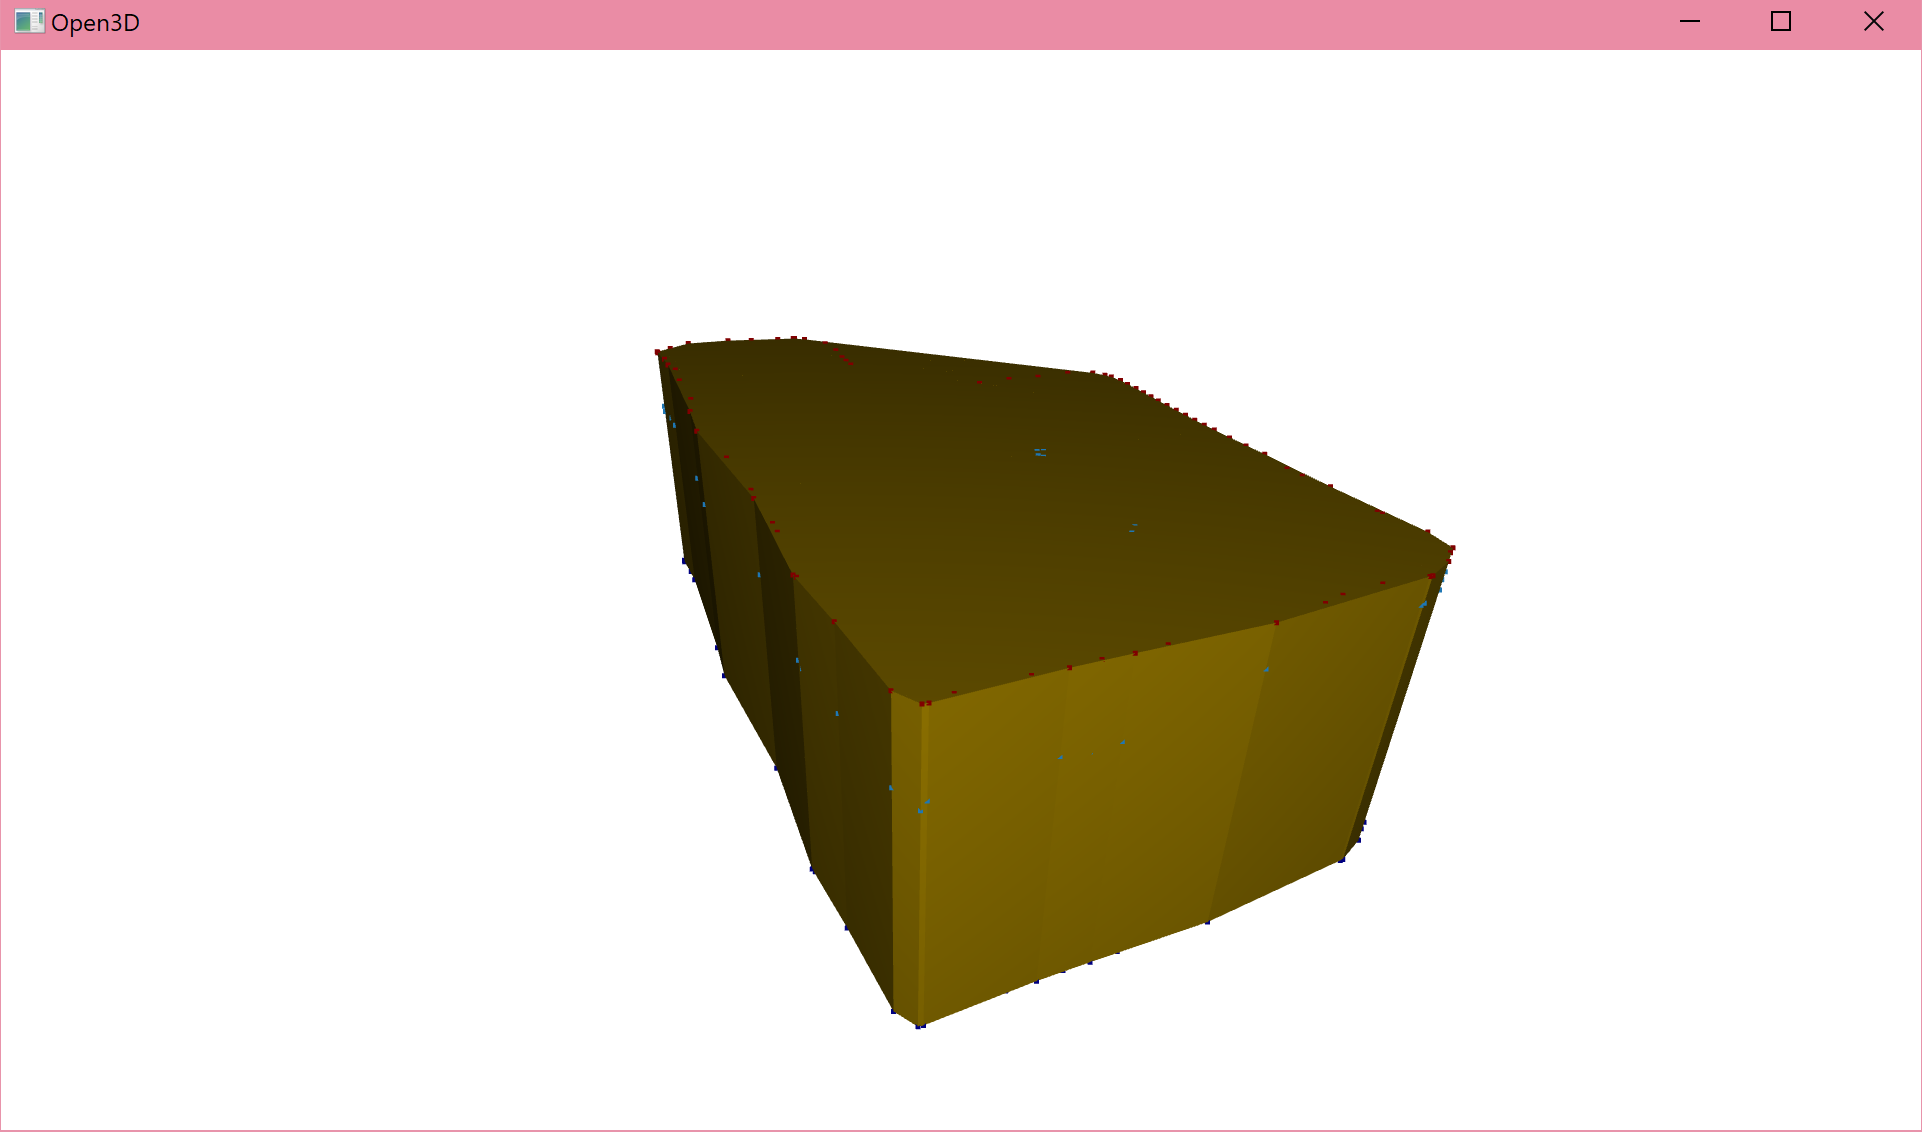

In [25]:
# 11. Final Operations & Export
# Reposition generated mesh to real world coordinates
mesh.translate(pcd_center)

# Export mesh
o3d.io.write_triangle_mesh('Results/building_sample.ply', mesh, write_ascii=False, compressed=True, write_vertex_normals=False, write_vertex_colors=False, write_triangle_uvs=False)

# Export the shapefile
building_gdf.to_file('Results/single_building.shp')